# Problem Description
In this project, I am trying to alter regular photos into monet pieces of art. The goal is to use a generative adversarial network to train my generator to alter photos into monet images and to train a discriminator that can distinguish between real and fake monet paintings.  This is a model that has to neural network models playing back and forth off eachother. With this set up I can iterate until the discriminator has a hard time distinguish the real monet paintings from the generator created fake paintings. 
## Structure of Notebook
I have broken this notebook up into the main sections of Data, EDA, Model Architecture, Model Analysis and Conclusion. I will discuss my ideas, implementation and results for each section at the top before the code and figures for each section. 

## Scoring
This project is a kaggle competition and it scores the submissions. It is using MiFID (Memorization-informed Fréchet Inception Distance). The smaller the MiFID, the better the score. 
There are several scoring metrics for GAN's and I want to discuss each one briefly.
### IS
This is a score given to generated images based on two things. One is how well they align with a certain labeled class like 'cat'. The other is how well distributed the images are over classes. It is a checking to see image quality and variety, but it does not compare the generated images to real images.
### FID
This is the Frechet Inception Distance. It uses the same model as IS to reduce the image into its features, but instead of taking the information from the output layer, it takes an intermediate layer that boils down the features of the image. It then measures the real and generated images feature means and covariances which are multivariate gaussians at this point. It then compares them using the Frechet Distance to see how different they are. A lower score indicates better generated images.
### MiFID
This is similar to FID but multiplies FID by a memorization term. This memorization term is there to check if the generator is just learning to copy the training data or to actually learn a method that creates similar images that are not the same. 


# Data description
There are 300 training tfrec monet files and 7028 tfrec photo files to use for the GAN. I chose to use the tfrec files to learn how to process a different file type.
Upon further inspection of the tfrec data, there are three different features for each tfrec file. They are image, image name and target. For the monet files, the target is monet and for the photo files the target is photo. Both monet and photo files have unique image names. Their image data also has the same dimensions and is consistent across all tfrec files (256,256,3).  Here 256x256 are the pixel dimensions whereas the 3 is indicating RGB channels.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
print("GPU devices:", tf.config.list_physical_devices('GPU'))
from tensorflow.keras import mixed_precision

# Enable mixed precision for faster compute time 
mixed_precision.set_global_policy('mixed_float16')

GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#See what the .tfrec file looks like for monet
tfrecord_folder_monet = "monet_tfrec"
tfrecord_folder_photo = "photo_tfrec"

#Glob all files in folder together
tfrecord_path_monet = tf.io.gfile.glob(tfrecord_folder_monet + "/*.tfrec")
tfrecord_path_photo = tf.io.gfile.glob(tfrecord_folder_photo + "/*.tfrec")

dataset_monet = tf.data.TFRecordDataset(tfrecord_path_monet)
dataset_photo = tf.data.TFRecordDataset(tfrecord_path_photo)

def inspect_record(dataset):
    for raw_record in dataset.take(1):
        # Tf.train.Example() is for tfrecs to make readable
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())

        # Each example should have same features, print features
        print("\nFeatures in this record:")
        for key in example.features.feature:
            print(key)
        # Only need first record to understand structure so break
        break

#Look at structure for one photo file and one monet file
print("\nMonet Record")
inspect_record(dataset_monet)
print("\nPhoto Record")
inspect_record(dataset_photo)



Monet Record

Features in this record:
target
image_name
image

Photo Record

Features in this record:
target
image_name
image


2025-04-23 11:24:30.969493: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-23 11:24:30.969513: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-23 11:24:30.969517: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-23 11:24:30.969533: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-23 11:24:30.969545: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


That is nice, so I only need one feature description for both sets of records.

In [3]:
# Define the feature description matching the TFRecord structure
feature_description = {
    'target': tf.io.FixedLenFeature([],tf.string),
    'image_name': tf.io.FixedLenFeature([],tf.string),
    'image': tf.io.FixedLenFeature([], tf.string) 
}

# This function parses records into their features
def parse_function(record):
    parsed_record = tf.io.parse_single_example(record, feature_description)

    # Decode the JPEG image stored in image feature and normalize (-1 to 1)
    image = tf.io.decode_jpeg(parsed_record['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = (image * 2.0) - 1.0

    # Extract the target and image_name features
    target = parsed_record['target']
    image_name = parsed_record['image_name']
    
    return image, target, image_name

# Map the dataset with your parsing function to decode the records
parsed_dataset_monet = dataset_monet.map(parse_function)
parsed_dataset_photo = dataset_photo.map(parse_function)

In [4]:
#check photo and monets for unique dimensions
def get_dimensions(dataset):
    unique_shapes = set()
    for image, _, _ in dataset:
        unique_shapes.add(image.shape)
    return unique_shapes

print("Monet Dimensions", get_dimensions(parsed_dataset_monet))
print("Photo Dimensions", get_dimensions(parsed_dataset_photo))


Monet Dimensions {TensorShape([256, 256, 3])}


2025-04-23 11:24:31.123243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Photo Dimensions {TensorShape([256, 256, 3])}


2025-04-23 11:24:32.491402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Exploratory Data Analysis

### Random Sample of Images
I took a few images from the monet data and the photo data to understand what each look like. The monet images are very distinct and have a unique style because they are all from the same painter. The photos sampled are natural places and look very different compared to the monet images. 

### Distribution of RGB values
This shows a distribution of RGB values per pixel in the photos dataset (Left) and the Monet dataset (Right). It is clear that the photos are in general darker than the monets since they have a much greater number of low valued pixels indicating darkness. The monets are full of color and do not have many fully dark or fully white spots. It appears green values for each pixel in the photos are dominant in the 50-150 range whereas the green values are dominant in the monets from the 150-200 range. It is interesting to see the color dominance differences in Monets vs Photos.  

### Brightness graph
Given the information above and general amount of darkness in the photos compared to monets looking at 0-10 valued pixels, I was assuming that monets would be brighter than the photos. It was confirmed by this graph and showed a distinct cluster of monets higher on the brightness scale compared to photos lower on the brightness scale. I'd assume this would be one easy target for the model to just increase the photos brightness to get closer to the Monet images. 

### Examine edge characteristics
I converted 4 random sample images of the monets and photos into greyscale versions that took the largest adjacent pixel difference and assigned the new image pixel that value. Lets say a pixel in the night sky was dark and the 8 surrounding pixels were also dark, then the new pixel would have a 0 difference and be dark in the new image. But if one of the eight pixels around the pixel was a star and very bright then that difference would be large and the new pixel would have a bright color calculated on that max difference. This is a way to determine edges and how harsh the contrasts are. I was expecting the monets to have softer and less defined edges. This was generally the case as seen below but not as stark as I was expecting. 

## Conclusions on EDA
Based on my EDA there are some fundemental differnces in the Monets vs Photo images. The brightness of monets is greater and they also have in general higher RGB pixel values. The Monets have slightly less distinct edges based on a small sample but it does appear there is a difference. In my model architecture I am going to want a discriminator that can identify these differences and a generator that can slowly work toward eliminating them. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


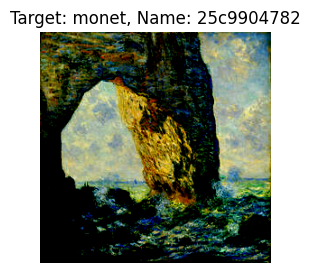

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


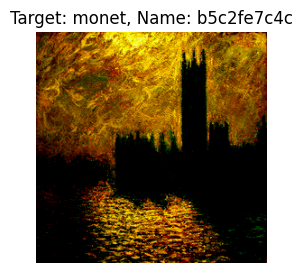

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


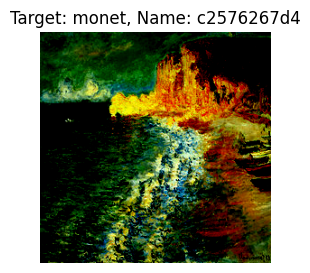

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].


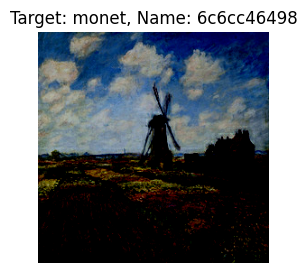

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


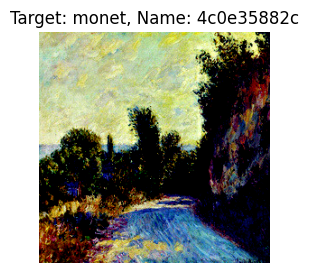

2025-04-23 11:24:32.648705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


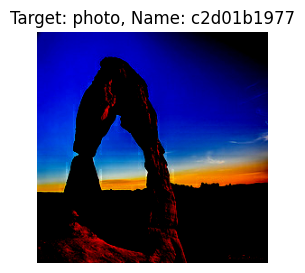

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


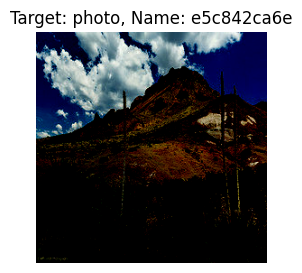

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


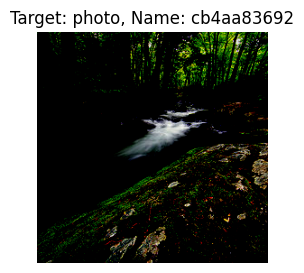

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


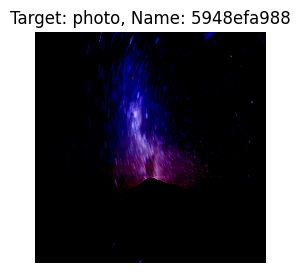

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8901961].


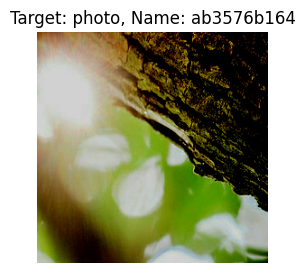

2025-04-23 11:24:32.777287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
#takes 5 images from dataset and plots them
def show_images(dataset):
    for image, target, image_name in dataset.take(5):
        plt.figure(figsize=(3, 3))
        plt.imshow(image.numpy())
        plt.title(f"Target: {target.numpy().decode('utf-8')}, Name: {image_name.numpy().decode('utf-8')}")
        plt.axis('off')
        plt.show()

#show 5 images for photos and monets
show_images(parsed_dataset_monet)
show_images(parsed_dataset_photo)

2025-04-23 11:24:33.245213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-23 11:24:33.728555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


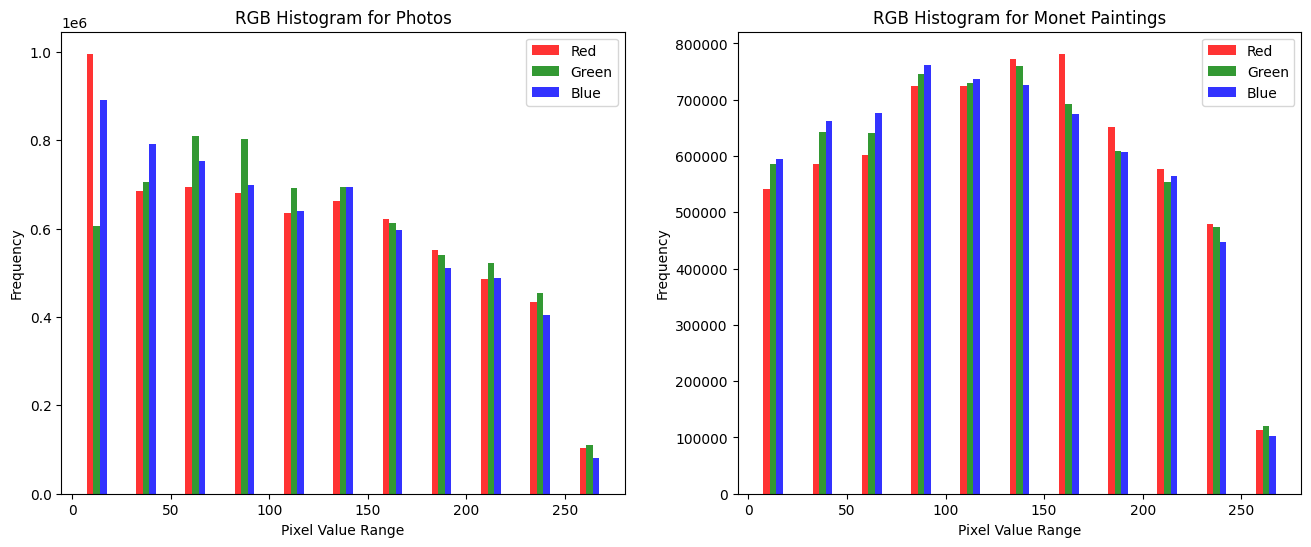

In [6]:
#this function takes a dataset and number of samples from that data set and adds pixel values for RGB to running totals
def aggregate_histograms(dataset, num_samples=100):
    # make bins of 25
    bin_edges = np.arange(0, 276, 25)  # 276 to include last few pixels 250-255
    num_bins = len(bin_edges) - 1
    
    total_r_hist = np.zeros(num_bins)
    total_g_hist = np.zeros(num_bins)
    total_b_hist = np.zeros(num_bins)
    
    # Iterate over images in the dataset
    for image, _, _ in dataset.take(num_samples):
        # Make sure it is 0-255, not 0-1
        image_np = image.numpy() * 255.0
        image_np = image_np.astype(np.uint8)
        
        # Getting each color from image_np
        r_hist, _ = np.histogram(image_np[:, :, 0], bins=bin_edges)
        g_hist, _ = np.histogram(image_np[:, :, 1], bins=bin_edges)
        b_hist, _ = np.histogram(image_np[:, :, 2], bins=bin_edges)
        
        total_r_hist += r_hist
        total_g_hist += g_hist
        total_b_hist += b_hist
        
    return total_r_hist, total_g_hist, total_b_hist, bin_edges


num_samples = 100
# Aggregate for Photos and Monet painting datasets
photo_r_hist, photo_g_hist, photo_b_hist, bin_edges = aggregate_histograms(parsed_dataset_photo, num_samples)
monet_r_hist, monet_g_hist, monet_b_hist, _ = aggregate_histograms(parsed_dataset_monet, num_samples)

import matplotlib.pyplot as plt

# Get centers of each bin and set bar_width
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bar_width = 10

# Create two subplots in one figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Axes[#] gives subplot to work with axis[0] for photos and axis[1] for Monets
axes[0].bar(bin_centers - bar_width/3, photo_r_hist, width=bar_width/3, color='red', alpha=0.8, label='Red')
axes[0].bar(bin_centers, photo_g_hist, width=bar_width/3, color='green', alpha=0.8, label='Green')
axes[0].bar(bin_centers + bar_width/3, photo_b_hist, width=bar_width/3, color='blue', alpha=0.8, label='Blue')
axes[0].set_title("RGB Histogram for Photos")
axes[0].set_xlabel("Pixel Value Range")
axes[0].set_ylabel("Frequency")
axes[0].legend()

axes[1].bar(bin_centers - bar_width/3, monet_r_hist, width=bar_width/3, color='red', alpha=0.8, label='Red')
axes[1].bar(bin_centers, monet_g_hist, width=bar_width/3, color='green', alpha=0.8, label='Green')
axes[1].bar(bin_centers + bar_width/3, monet_b_hist, width=bar_width/3, color='blue', alpha=0.8, label='Blue')
axes[1].set_title("RGB Histogram for Monet Paintings")
axes[1].set_xlabel("Pixel Value Range")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.show()


2025-04-23 11:24:34.563857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-23 11:24:35.116659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


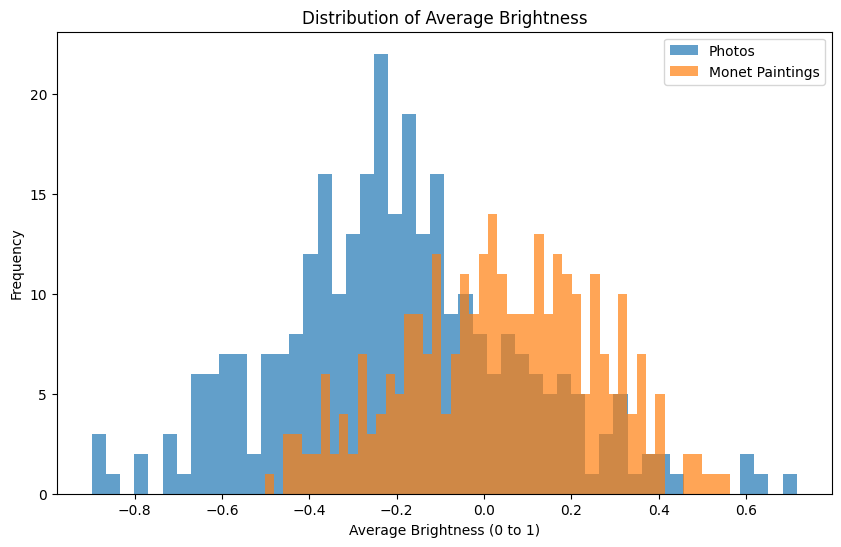

In [7]:
#plot average brightness of images vs Monets: based on the above data I'd expect the Monets to be brighter

#takes a dataset with images and calculates the images average brightness and adds it to the brightness values array
def compute_average_brightness(dataset, num_samples=100):
    brightness_values = []
    for image, _, _ in dataset.take(num_samples):
        # Convert RGB image to grayscale. Converts each pixel to one brightness value from RGB values
        grayscale_image = tf.image.rgb_to_grayscale(image)
        # Compute the average brightness as the mean of all pixel intensities.
        avg_brightness = tf.reduce_mean(grayscale_image)
        brightness_values.append(avg_brightness.numpy())
    return brightness_values

# Monet and Photo brightness for 100 samples
photo_brightness = compute_average_brightness(parsed_dataset_photo, num_samples=300)
monet_brightness = compute_average_brightness(parsed_dataset_monet, num_samples=300)

# Plot the brightness
plt.figure(figsize=(10, 6))

# Plot histograms for both datasets on the same graph.
plt.hist(photo_brightness, bins=50, alpha=0.7, label="Photos")
plt.hist(monet_brightness, bins=50, alpha=0.7, label="Monet Paintings")

plt.xlabel("Average Brightness (0 to 1)")
plt.ylabel("Frequency")
plt.title("Distribution of Average Brightness")
plt.legend()
plt.show()


2025-04-23 11:24:35.234624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


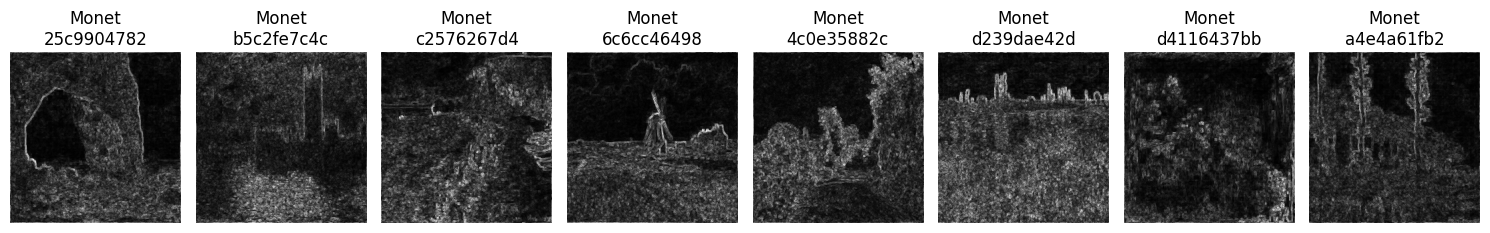

2025-04-23 11:24:35.522495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


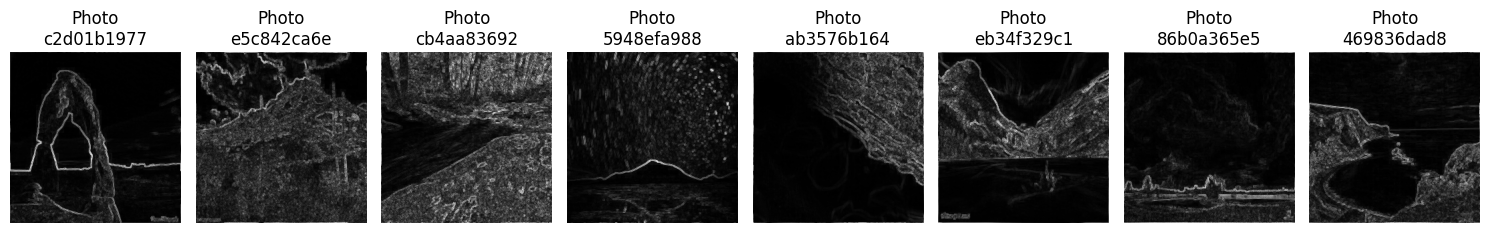

In [8]:
# Next, I will implement a method to convert these monets and photos to an edge detection version to see what how starkly objets transistion from one to another. 
import tensorflow as tf

# Find edges by calculating largest diffrence between neighboring pixels
def max_adjacent_difference_tf(gray_image):
    # Compute horizontal and vertical neighbors
    diff_right = tf.abs(gray_image - tf.roll(gray_image, shift=-1, axis=1))
    diff_left  = tf.abs(gray_image - tf.roll(gray_image, shift=1, axis=1))
    diff_up    = tf.abs(gray_image - tf.roll(gray_image, shift=-1, axis=0))
    diff_down  = tf.abs(gray_image - tf.roll(gray_image, shift=1, axis=0))
    
    # Compute diagnols
    diff_up_right   = tf.abs(gray_image - tf.roll(tf.roll(gray_image, shift=-1, axis=0), shift=-1, axis=1))
    diff_up_left    = tf.abs(gray_image - tf.roll(tf.roll(gray_image, shift=-1, axis=0), shift=1, axis=1))
    diff_down_right = tf.abs(gray_image - tf.roll(tf.roll(gray_image, shift=1, axis=0), shift=-1, axis=1))
    diff_down_left  = tf.abs(gray_image - tf.roll(tf.roll(gray_image, shift=1, axis=0), shift=1, axis=1))
    
    # Find greatest difference in pixels
    all_diffs = tf.stack([
        diff_right, diff_left, diff_up, diff_down,
        diff_up_right, diff_up_left, diff_down_right, diff_down_left
    ], axis=0)
    
    max_diff = tf.reduce_max(all_diffs, axis=0)
    return max_diff


# Convert images into edge detected versions to see variation in color pixel to pixel
def display_brightness_variation(dataset, title, num_samples=4):
    samples = list(dataset.take(num_samples))
    plt.figure(figsize=(15, 4))
    
    for i, (image, target, image_name) in enumerate(samples):
        # Convert RGB to greyscale
        gray_image = tf.image.rgb_to_grayscale(image)
        # Call function above
        diff_image = max_adjacent_difference_tf(gray_image)
        
        # Plot the new image
        plt.subplot(1, num_samples, i+1)
        plt.imshow(diff_image.numpy().squeeze(), cmap='gray')
        name_str = image_name.numpy().decode('utf-8') if isinstance(image_name.numpy(), bytes) else str(image_name.numpy())
        plt.title(f"{title}\n{name_str}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Display 8 samples from the Monet and Photo dataset
display_brightness_variation(parsed_dataset_monet, title="Monet", num_samples=8)
display_brightness_variation(parsed_dataset_photo, title="Photo", num_samples=8)


# Model Architecture

### Normalize input 
Want to have input range from [-1,1] and this was done above. Now, plan to augment images so that there is more monet variety in that dataset. This is important so the discriminator doesn't just learn the small monet dataset.  

### Model comparision : Pix2pix vs CycleGAN
I am planning to use a Cycle GAN model. I looked into Pix2Pix which is close to what I need but it works best with paired input to output images. Here we have input photos that are not coupled to Monet paintings. A Cycle GAN model should work better for this input and output. In CycleGAN there are two generators and two discriminators. There is a generator for converting photos to monets and monets to photos. There is also a discriminator that learns to differentiate between real photos and generated photos and a discriminator that learns to differentiate between real monets and generated monets. 

### Generator comparison U-Net vs ResNet
For the generators I will use a resnet implementation that down samples images but adds many more layers of depth to them. This is then sent through a resnet which carries residual information through the network along with modified information. It is then decoded, so upsampled back to the orginal size and depth. 

### Discriminator PatchGAN
Doing research on cycle GANS and image to image generation in general lead me to the patchGAN discriminator. This discriminator looks at overlapping n by n patches of an image and takes scores on each patch so it is an average of many patch scores. This allows the discriminator to focus on style of the image vs the overall image. If I wanted to focus on the overall image and get one score, I could use a CNN GAN but this wouldn't be as helpful since the monets have a certain clear style. Also, PatchGANS are computationally quick which is useful when there are two discriminators and two generators used in this assignment. 

### Loss function
I am going to try two models here. One with a LSGAN loss and one with a hinge loss. I am going to compare generator losses of each and chose the preffered model from that assessment and sample pictures run through each generator. LSGAN loss Excentuates small errors which still allows progress to be made for the generator even when the discriminator is very confident and this results in smoother images. Hinge loss focuses on pushing images just beyond the margin which results in better textures.
### Outcome of two models 
LSGAN 

### Hyperparameter Tuning
tune parameters


In [9]:
#Normalize and Augment images 
AUTOTUNE    = tf.data.AUTOTUNE #This allows for tensorflow to adjust parallelization instead of guessing
BATCH_SIZE  = 1   # this will allow for one photo and monet to be processed at a time

# Augmentation for Monet paintings, flipping and adjusting brightness at random
def augment_monet(image):
    # random flip of image
    image = tf.image.random_flip_left_right(image)
    # random brightness change
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image

# Monet dataset
monet_ds = (
    parsed_dataset_monet
    # drop target and name
    .map(lambda img, t, n: img, num_parallel_calls=AUTOTUNE)
    # apply augment function above
    .map(lambda img: augment_monet(img), num_parallel_calls=AUTOTUNE)
    .shuffle(300)  
    .repeat()       
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Photo Dataset
photo_ds = (
    parsed_dataset_photo
    #Just use image data
    .map(lambda img, t, n: img,      num_parallel_calls=AUTOTUNE)
    .shuffle(7000)  
    .repeat()   
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

train_ds = tf.data.Dataset.zip((photo_ds, monet_ds))


In [10]:
from tensorflow.keras import layers
from tensorflow.keras.layers import LayerNormalization

"""
    A ResNet encoder and decoder with residual blocks. This will be used for both generators
    
    Args:
      num_downsampling: number of Conv layers with stride = 2.
      num_res_blocks:    number of ResNet blocks in the bottleneck.
      base_filters:      number of filters in the first conv layer.
    """
def build_generator(num_downsampling=2, num_res_blocks=6, base_filters=32):

    x_in = layers.Input(shape=(256,256,3))
    x = x_in

    # One conv with no downsampling
    x = layers.Conv2D(base_filters, 7, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = LayerNormalization(axis=[1,2], epsilon=1e-5)(x)
    x = layers.ReLU()(x)

    # This loop adds downsampling blocks
    filters = base_filters
    for i in range(num_downsampling):
        filters *= 2
        x = layers.Conv2D(filters, 3, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
        x = LayerNormalization(axis=[1,2], epsilon=1e-5)(x)
        x = layers.ReLU()(x)

    # This is residual loop 
    for i in range(num_res_blocks):
        y = layers.Conv2D(filters, 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
        y = LayerNormalization(axis=[1,2], epsilon=1e-5)(y)
        y = layers.ReLU()(y)

        y = layers.Conv2D(filters, 3, padding='same', use_bias=False, kernel_initializer='he_normal')(y)
        y = LayerNormalization(axis=[1,2], epsilon=1e-5)(y)

        x = layers.add([x, y])  # skip connection

    # This is upsampling loop and reverses down sampling loop
    for i in range(num_downsampling):
        filters //= 2
        x = layers.Conv2DTranspose(filters, 4, strides=2, padding='same',use_bias=False, kernel_initializer='he_normal')(x)
        x = LayerNormalization(axis=[1,2], epsilon=1e-5)(x)
        x = layers.ReLU()(x)

    # output conv with activation tanh
    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return tf.keras.Model(x_in, x, name='ResNetGenerator')

"""
    A PatchGAN discriminator, which takes sections of the input and focus's on patches to assess
    
    Args:
      base_filters: number of filters in the first conv layer.
      n_layers:     number of times to double filters via stride‑2 convs.
    """
def build_discriminator(base_filters=32, n_layers=3):
    
    x_in = layers.Input(shape=(256,256,3))
    x = x_in

    # down sampling layer
    x = layers.Conv2D(base_filters, 4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(0.2)(x)

    # another downsampling layer with layer normalization
    filters = base_filters
    for i in range(n_layers):
        filters = min(filters * 2, 512)
        x = layers.Conv2D(filters, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
        x = LayerNormalization(axis=[1,2], epsilon=1e-5)(x)
        x = layers.LeakyReLU(0.2)(x)

    # conv to single channel prediction map and takes into account different patches
    x = layers.Conv2D(1, 4, padding='same', kernel_initializer='he_normal')(x)

    return tf.keras.Model(x_in, x, name='PatchDiscriminator')


In [17]:
import time

#Set up all generators, discriminators, loss functions and optimizers
G = build_generator()      # Photo to Monet
F = build_generator()      # Monet to Photo
D_Y = build_discriminator()  # Discriminate Monet vs fake-Monet
D_X = build_discriminator()  # Discriminate Photo vs fake-Photo

# Least‐squares GAN losses
mse = tf.keras.losses.MeanSquaredError()
# Cycle + identity losses
mae = tf.keras.losses.MeanAbsoluteError()

# Optimizers, using Adam
g_opt   = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
f_opt   = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_y_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_x_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Loss weights
λ_cycle = 10.0
λ_id    = 0.5

#Training both generators and both discriminators
@tf.function
def train_step(x_real, y_real, trainingLoss):
    # x_real: photos, y_real: Monet; both shape [B,H,W,3], values in [-1,1]
    with tf.GradientTape(persistent=True) as tape:
        #translate reals to fakes and generated fakes back
        y_fake  = G(x_real, training=True)
        x_fake  = F(y_real, training=True)
        x_cycle = F(y_fake,   training=True)
        y_cycle = G(x_fake,   training=True)

        # Give generator real photo or monet
        x_id = F(x_real,   training=True)
        y_id = G(y_real,   training=True)

        # train discriminator on fakes and real images
        d_y_real = D_Y(y_real, training=True)
        d_y_fake = D_Y(y_fake, training=True)
        d_x_real = D_X(x_real, training=True)
        d_x_fake = D_X(x_fake, training=True)

        #calculate adversarial loss with LSGAN or Hinge
        if trainingLoss == 'LSGAN':
            G_adv = mse(tf.ones_like(d_y_fake), d_y_fake)
            F_adv = mse(tf.ones_like(d_x_fake), d_x_fake)
            D_Y_loss = 0.5*(mse(tf.ones_like(d_y_real), d_y_real) +
                            mse(tf.zeros_like(d_y_fake), d_y_fake))
            D_X_loss = 0.5*(mse(tf.ones_like(d_x_real), d_x_real) +
                            mse(tf.zeros_like(d_x_fake), d_x_fake))
        elif trainingLoss == 'Hinge':
            D_Y_loss = 0.5 * (
                tf.reduce_mean(tf.nn.relu(1.0 - d_y_real)) +
                tf.reduce_mean(tf.nn.relu(1.0 + d_y_fake))
            )
            D_X_loss = 0.5 * (
                tf.reduce_mean(tf.nn.relu(1.0 - d_x_real)) +
                tf.reduce_mean(tf.nn.relu(1.0 + d_x_fake))
            )
            G_adv = -tf.reduce_mean(d_y_fake)
            F_adv = -tf.reduce_mean(d_x_fake)
            G_adv = tf.cast(G_adv, cycle_loss.dtype)
            F_adv = tf.cast(F_adv, cycle_loss.dtype)

        else:
            raise ValueError(f"Unknown trainingLoss: {trainingLoss}")

        # Cycle consistency
        cycle_loss = mae(x_real, x_cycle) + mae(y_real, y_cycle)
        cycle_loss = λ_cycle * cycle_loss

        # Identity loss
        id_loss = mae(x_real, x_id) + mae(y_real, y_id)
        id_loss = λ_id * id_loss

        # Total generator losses
        G_loss = G_adv + cycle_loss + id_loss
        F_loss = F_adv + cycle_loss + id_loss

    # Compute gradients
    grads_G  = tape.gradient(G_loss, G.trainable_variables)
    grads_F  = tape.gradient(F_loss, F.trainable_variables)
    grads_DY = tape.gradient(D_Y_loss, D_Y.trainable_variables)
    grads_DX = tape.gradient(D_X_loss, D_X.trainable_variables)

    # Apply gradients with optimization function specified above
    g_opt.apply_gradients(zip(grads_G,  G.trainable_variables))
    f_opt.apply_gradients(zip(grads_F,  F.trainable_variables))
    d_y_opt.apply_gradients(zip(grads_DY, D_Y.trainable_variables))
    d_x_opt.apply_gradients(zip(grads_DX, D_X.trainable_variables))
    del tape

    return G_loss, F_loss, D_Y_loss, D_X_loss

#Training on 6 epochs, recording histories to plot
def testModel(trainingLoss):
    EPOCHS = 6
    history = {'G':[], 'F':[], 'D_Y':[], 'D_X':[]}
    STEPS_PER_EPOCH = 250

    for epoch in range(1, EPOCHS+1):
        G_epoch = F_epoch = D_Y_epoch = D_X_epoch = tf.constant(0.0)
        steps = 0
        start = time.time()

        for step, (x_batch, y_batch) in enumerate(train_ds.take(STEPS_PER_EPOCH), start=1):
            G_l, F_l, D_Y_l, D_X_l = train_step(x_batch, y_batch, trainingLoss)
            G_epoch  += G_l
            F_epoch  += F_l
            D_Y_epoch += D_Y_l
            D_X_epoch += D_X_l
            steps += 1
        duration = time.time() - start
        print(f"Epoch {epoch} took {duration/60:.2f} minutes")
        # Average losses
        history['G'].append((G_epoch/steps).numpy())
        history['F'].append((F_epoch/steps).numpy())
        history['D_Y'].append((D_Y_epoch/steps).numpy())
        history['D_X'].append((D_X_epoch/steps).numpy())

        print(f"Epoch {epoch:02d} — G: {history['G'][-1]:.4f}, F: {history['F'][-1]:.4f}, "
            f"D_Y: {history['D_Y'][-1]:.4f}, D_X: {history['D_X'][-1]:.4f}")

        # Generated photo and creataed monet every 2 epochs
        if epoch % 2 == 0:
            img = next(iter(photo_ds))[0]               
            img = tf.expand_dims(img, axis=0)           
            fake = G(img, training=False)
            fake = tf.cast(fake, tf.float32).numpy()
            fake = (fake + 1.0) / 2.0
            inp  = (img + 1.0) / 2.0

            plt.figure(figsize=(6,3))
            plt.subplot(1,2,1)
            plt.title("Photo")
            plt.imshow(inp[0]); plt.axis('off')
            plt.subplot(1,2,2)
            plt.title(f"Epoch {epoch}")
            plt.imshow(fake[0]); plt.axis('off')
            plt.show()

    #loss curves 
    plt.figure(figsize=(10,5))
    plt.plot(history['G'],  label="G_loss")
    plt.plot(history['F'],  label="F_loss")
    plt.title("Training Losses"); plt.legend(); plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(history['D_Y'], label="D_Y_loss")
    plt.plot(history['D_X'], label="D_X_loss")
    plt.title("Training Losses"); plt.legend(); plt.show()


2025-04-23 17:47:22.337856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 took 7.12 minutes
Epoch 01 — G: 8.1161, F: 8.1225, D_Y: 0.3668, D_X: 0.3591


2025-04-23 17:52:43.615832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 took 5.35 minutes
Epoch 02 — G: 6.4645, F: 6.4527, D_Y: 0.2512, D_X: 0.2511


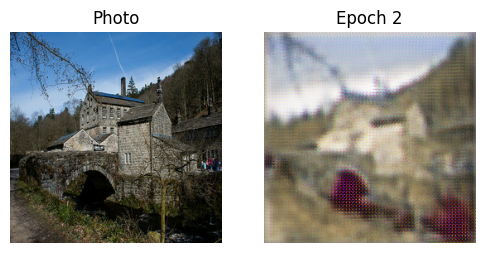

2025-04-23 17:57:57.133003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 took 5.15 minutes
Epoch 03 — G: 6.1288, F: 6.1233, D_Y: 0.2316, D_X: 0.2342


2025-04-23 18:03:45.088644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 took 5.80 minutes
Epoch 04 — G: 6.0209, F: 5.9723, D_Y: 0.2159, D_X: 0.2300


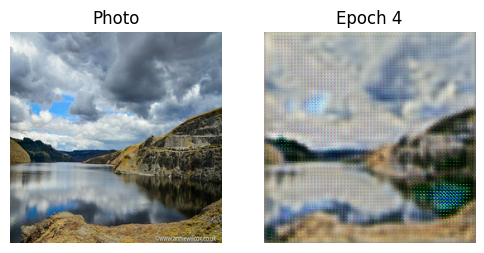

2025-04-23 18:09:27.550696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5 took 5.61 minutes
Epoch 05 — G: 6.0088, F: 5.9565, D_Y: 0.2064, D_X: 0.2221


2025-04-23 18:14:52.643776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6 took 5.42 minutes
Epoch 06 — G: 5.7854, F: 5.7425, D_Y: 0.2104, D_X: 0.2219


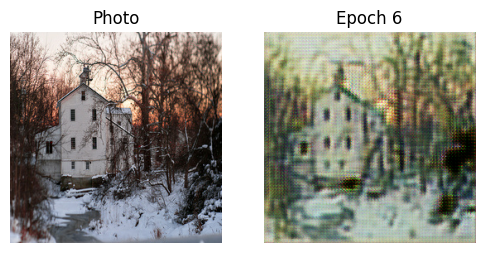

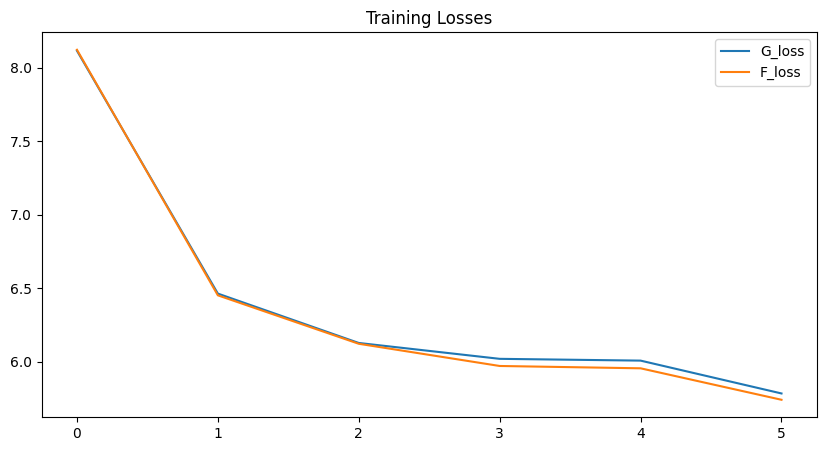

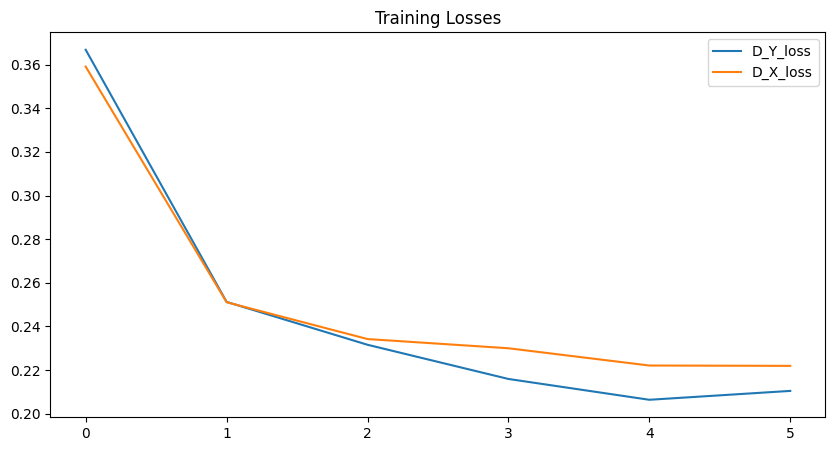

In [18]:
testModel('LSGAN')

In [19]:
testModel('Hinge')

TypeError: in user code:

    File "/var/folders/fx/dljhb1xs01zd1r8n975gbtcc0000gn/T/ipykernel_63990/681893949.py", line 77, in train_step  *
        G_loss = G_adv + cycle_loss + id_loss

    TypeError: Input 'y' of 'AddV2' Op has type float32 that does not match type float16 of argument 'x'.


 Uses one architecture and explanation for choosing that particular architecture/loss function and hyperparameter tuning and compares several architectures/loss functions. 

Results and Analysis 
To receive full points for this section, the author needs to address the following:
Results
Does it include results in the form of tables, figures, etc.? 
Analysis 
Does it include analysis of results:
the reasoning of why something worked well or why it didn't work
description of troubleshooting steps.
a hyperparameter optimization procedure summary.
35 pts
Includes all of the following:  result tables or visualizations, conclusion/summary for hyperparameter tuning, reasoning on why some models or hyperparameters work well or why they do not, and explains any troubleshooting procedure.

Includes all of the following: basic reiteration of result and discussion of learning and takeaways and discussion of why something didn’t work, and suggestions for ways to improve.